"""
Adam SenseAI - Multimodal LangChain Agent + Chroma DB

- Ingest selected YouTube cooking videos
- Transcribe with Whisper
- Build / load Chroma DB
- Persona-aligned RAG chain (Adam Ragusea style)
- ReAct agent with tools + memory
- Gradio UI with:
    - Text questions + audio answers
    - Voice questions + audio answers
"""

In [1]:
import sys
print(sys.executable)

c:\Users\User\langchain-demo\.venv\Scripts\python.exe


**DEPENDANCIES**

In [2]:
%pip install \
    "langchain==0.1.20" \
    langchain-openai \
    langchain-community \
    chromadb \
    youtube-transcript-api \
    yt-dlp \
    openai \
    openai-whisper \
    tiktoken \
    pydub \
    gTTS \
    gradio \
    python-dotenv \
    


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install -U "gradio>=4.0.0"


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install "langsmith>=0.1.60"


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**IMPORTS** 

In [1]:
import os
import uuid
import tempfile
import yt_dlp
import whisper
import gradio as gr

from gtts import gTTS
from pathlib import Path
from typing import List, Tuple



from youtube_transcript_api import YouTubeTranscriptApi
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory
from langchain.agents import create_react_agent, AgentExecutor

from IPython.display import Audio, display
from dotenv import load_dotenv


**PATHS & BASIC SETUP**

In [2]:
BASE_DIR = Path.cwd()  # project root / current working directory
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw_transcripts"
AUDIO_DIR = DATA_DIR / "audio"
CHROMA_DIR = DATA_DIR / "chroma_db"

for d in [RAW_DIR, AUDIO_DIR, CHROMA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("RAW_DIR:", RAW_DIR)
print("AUDIO_DIR:", AUDIO_DIR)
print("CHROMA_DIR:", CHROMA_DIR)


BASE_DIR: c:\Users\User\langchain-demo
RAW_DIR: c:\Users\User\langchain-demo\data\raw_transcripts
AUDIO_DIR: c:\Users\User\langchain-demo\data\audio
CHROMA_DIR: c:\Users\User\langchain-demo\data\chroma_db


**KEYS: OpenAI_API_Key & LangChain_API_Key**

In [3]:


# Load environment variables from .env
load_dotenv()

# Optional: sanity check
print("OPENAI_API_KEY set:", bool(os.getenv("OPENAI_API_KEY")))
print("LANGCHAIN_API_KEY set:", bool(os.getenv("LANGCHAIN_API_KEY")))
print("LANGCHAIN_PROJECT:", os.getenv("LANGCHAIN_PROJECT"))


OPENAI_API_KEY set: True
LANGCHAIN_API_KEY set: True
LANGCHAIN_PROJECT: yt-rag-demo


**Wisper Model**

In [5]:
# Loading Whisper once (can change model size if needed)
whisper_model = whisper.load_model("small")



**1. YOUTUBE INGESTION + TRANSCRIPTION**

YouTube Video Ingestion Pipeline + Wisper
✔ speech recognition
✔ youtube retrieval
✔ transcript processing
✔ LangChain text preprocessing
✔ RAG-ready docs

In [6]:
def extract_video_id(url: str) -> str:
    """Extract YouTube video id using yt-dlp."""
    ydl_opts = {"quiet": True, "skip_download": True}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
    return info["id"]



def download_youtube_audio(url: str) -> Tuple[str, Path]:
    """
    Download best audio from a YouTube URL as mp3.
    Returns (video_id, audio_path).
    """
    vid = extract_video_id(url)

    # Let yt-dlp / ffmpeg decide extension, then we pick the mp3 afterwards
    outtmpl = str(AUDIO_DIR / f"{vid}.%(ext)s")

    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": outtmpl,
        "quiet": True,
        "postprocessors": [
            {
                "key": "FFmpegExtractAudio",
                "preferredcodec": "mp3",
                "preferredquality": "192",
            }
        ],
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

    # After postprocessing, we expect an mp3 with this video id
    mp3_candidates = list(AUDIO_DIR.glob(f"{vid}.mp3"))
    if not mp3_candidates:
        raise FileNotFoundError(
            f"Expected an mp3 file for video id {vid} in {AUDIO_DIR}, but none was found."
        )

    # If multiple, just take the first one
    audio_path = mp3_candidates[0]
    return vid, audio_path


def transcribe_audio(path: Path) -> str:
    """Transcribe audio file with Whisper."""
    result = whisper_model.transcribe(str(path))
    return result["text"]



def save_transcript(video_id: str, text: str) -> Path:
    """Save transcript into data/raw_transcripts/{video_id}.txt."""
    outpath = RAW_DIR / f"{video_id}.txt"
    outpath.write_text(text, encoding="utf-8")
    return outpath



def ingest_single_video(url: str) -> Tuple[str, Path]:
    """
    Ingest a single YouTube video:
        1) download audio
        2) transcribe
        3) save transcript
    Returns (video_id, transcript_path).
    """
    vid, audio_path = download_youtube_audio(url)
    print(f"[Ingest] Downloaded audio for video id: {vid}")
    transcript = transcribe_audio(audio_path)
    print(f"[Ingest] Transcribed audio for video id: {vid}")
    tpath = save_transcript(vid, transcript)
    print(f"[Ingest] Saved transcript to: {tpath}")
    return vid, tpath


def ingest_selected_videos(urls: List[str]) -> List[Tuple[str, Path]]:
    """
    Ingest all selected YouTube URLs.
    This does NOT build the DB yet; that happens in a separate function.
    """
    results = []
    for url in urls:
        try:
            print(f"\n=== Processing URL: {url} ===")
            vid, tpath = ingest_single_video(url)
            results.append((vid, tpath))
        except Exception as e:
            print(f"[ERROR] Could not ingest {url}: {e}")
    return results


In [10]:
# Test :
# ingest_selected_videos(["https://youtu.be/p8-_DJd1Ii8"])  # Adam Ragusea video

**2. BUILD / LOAD CHROMA DB**

In [7]:
def load_transcript_docs() -> List[Document]:
    """Load all transcript .txt files as LangChain Documents."""
    docs: List[Document] = []
    for path in RAW_DIR.glob("*.txt"):
        text = path.read_text(encoding="utf-8")
        if text.strip():
            docs.append(
                Document(
                    page_content=text,
                    metadata={"source": path.name, "video_id": path.stem},
                )
            )
    return docs



def chunk_documents(docs: List[Document]) -> List[Document]:
    """Split documents into overlapping chunks for RAG."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=200,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    return splitter.split_documents(docs)



def build_chroma_db() -> Chroma:
    """
    Build the Chroma vector DB from all transcripts in RAW_DIR.

    IMPORTANT:
    - Call this AFTER you've ingested the videos you want.
      (i.e., after ingest_selected_videos([...]) )
    """
    print("[DB] Loading transcripts from:", RAW_DIR)
    docs = load_transcript_docs()
    print(f"[DB] Loaded {len(docs)} document(s).")

    if not docs:
        raise RuntimeError("No transcripts found. Ingest some YouTube videos first.")

    chunks = chunk_documents(docs)
    print(f"[DB] Created {len(chunks)} chunk(s).")

    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    vectordb = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=str(CHROMA_DIR),
        collection_name="adam_collection",
    )

    vectordb.persist()
    print("[DB] Chroma DB built & persisted at:", CHROMA_DIR)
    return vectordb


def load_chroma_db() -> Chroma:
    """
    Load an existing Chroma DB from disk.
    Use this in a new session instead of rebuilding.
    """
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectordb = Chroma(
        embedding_function=embeddings,
        persist_directory=str(CHROMA_DIR),
        collection_name="adam_collection",
    )
    print("[DB] Loaded Chroma DB from:", CHROMA_DIR)
    return vectordb

def add_transcript_to_chroma(vectordb: Chroma, video_id: str) -> None:
    """
    Incrementally add ONE transcript to an existing Chroma DB.

    If the DB is empty or not yet built, you should call build_chroma_db()
    instead of this function.
    """
    path = RAW_DIR / f"{video_id}.txt"
    if not path.exists():
        raise FileNotFoundError(f"No transcript file found for video id: {video_id}")

    text = path.read_text(encoding="utf-8").strip()
    if not text:
        print(f"[DB] Transcript for {video_id} is empty, skipping.")
        return

    # Wrap in a Document and chunk just this transcript
    doc = Document(
        page_content=text,
        metadata={"source": path.name, "video_id": video_id},
    )
    chunks = chunk_documents([doc])
    print(f"[DB] Adding {len(chunks)} chunk(s) for video {video_id} to Chroma...")

    vectordb.add_documents(chunks)
    vectordb.persist()
    print("[DB] Incremental update persisted.")


**3. ADAM PERSONA & TOOLS**

In [8]:
ADAM_PERSONA = """
You are an unofficial Adam Ragusea–style cooking assistant.

Your highest priorities:
1. FIRST, use the transcript for information whenever available.
2. SECOND, express reasoning in Adam’s signature trade-off style (“on the one hand / on the other hand”) whenever the topic involves any kind of choice, preference, alternative technique, or difference in outcome.
3. If the transcript does not address the question, you must explicitly state that and THEN give a brief, trade-off-based explanation from general cooking science.

========================
MANDATORY STRUCTURE
========================

1. **Transcript check section (always required):**
   - Summarize exactly what the transcript says.
   - If it doesn’t say anything, explicitly say:  
     “Transcript check: the transcript does not address this topic.”

2. **Trade-off reasoning section (always required when relevant):**
   Use this pattern verbatim:
   - "On the one hand, ..."
   - "On the other hand, ..."

   You must include **at least one** on-the-one-hand / on-the-other-hand contrast whenever the question involves:
   - techniques (boiling vs steaming, pan types, salting methods)
   - timing (salting early vs late)
   - ingredients (butter vs oil, yogurt vs sour cream)
   - any decision where Adam would discuss pros/cons

3. **Final summary section:**
   - Short, crisp, Adam-style conclusion.

========================
ADDITIONAL RULES
========================
- Never invent claims not supported by the transcript.
- When using general cooking knowledge, keep it brief and clearly separated from transcript info.
- Maintain Adam’s tone: calm, friendly, and science-minded.
"""


In [9]:
def create_tools(vectordb: Chroma) -> List[Tool]:
    """
    Create agent tools based on the current Chroma DB and transcript files.
    """

    retriever = vectordb.as_retriever(search_kwargs={"k": 4})

    def retrieve_tool(query: str) -> str:
        """
        Use retriever to fetch relevant chunks.
        """
        docs = retriever.get_relevant_documents(query)
        return "\n\n---\n\n".join(d.page_content for d in docs)

    def get_transcript_tool(video_id: str) -> str:
        """
        Get full transcript text for a given video id (file name without .txt).
        """
        path = RAW_DIR / f"{video_id}.txt"
        if not path.exists():
            return f"No transcript found for video id: {video_id}"
        return path.read_text(encoding="utf-8")

    tools = [
        Tool(
            name="retrieve_docs",
            func=retrieve_tool,
            description=(
                "Use this to look up relevant transcript chunks from the ingested YouTube cooking videos. "
                "Best for answering questions about techniques, explanations, and steps."
            ),
        ),
        Tool(
            name="get_transcript",
            func=get_transcript_tool,
            description=(
                "Use this to get the full transcript for a specific video id. "
                "Video id = transcript file name without .txt"
            ),
        ),
    ]

    return tools



**4. RAG PROMPT + RAG CHAIN + AGENT**

In [10]:
ADAM_RAG_PROMPT = ChatPromptTemplate.from_messages([
    ("system", ADAM_PERSONA),
    (
        "system",
        """
You will answer the user's question using the provided transcript context.

Rules:
1. FIRST analyze whether the transcript answers the question.
2. If the context is helpful, quote or summarize it.
3. If the context is not helpful, say something like:
   "The transcript doesn't fully address this, but here's what I know..."
4. Then continue using cooking science and general knowledge.
5. Use Adam-style trade-off reasoning.

Transcript context:
{context}
        """,
    ),
    ("human", "{input}"),
])

def build_rag_and_agent(vdb: Chroma):
    """
    Given a Chroma vectordb, create:
      - RAG chain (rag_chain)
      - ReAct agent with tools + memory (agent)
    """
    retriever = vdb.as_retriever(search_kwargs={"k": 4})

    # Shared LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

    # ---- RAG chain ----
    document_chain = create_stuff_documents_chain(
        llm=llm,
        prompt=ADAM_RAG_PROMPT,
    )

    rag_chain = create_retrieval_chain(
        retriever=retriever,
        combine_docs_chain=document_chain,
    )

    # ---- Tools + memory for agent ----
    tools = create_tools(vdb)

    memory = ConversationBufferMemory(
        memory_key="chat_history",
        return_messages=True,
    )

    # IMPORTANT: include {tools} and {tool_names} in the prompt
    react_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            ADAM_PERSONA
            + "\n\nYou have access to the following tools:\n{tools}\n\n"
              "When using them, refer to them by name from this list: {tool_names}."
        ),
        ("system", "You can call tools when needed. Think step-by-step."),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])

    react_agent = create_react_agent(
        llm=llm,
        tools=tools,
        prompt=react_prompt,
    )

    agent = AgentExecutor(
        agent=react_agent,
        tools=tools,
        verbose=True,
        memory=memory,
    )

    return rag_chain, agent


    


**5. MULTIMODAL HELPERS (TTS + audio QA)** 

In [11]:
def text_to_speech_file(text: str) -> str:
    """
    Convert text to an MP3 file using gTTS and return file path.
    Used for voice answers (multimodal output).
    """
    if not text or not text.strip():
        return ""

    tmp_dir = Path(tempfile.gettempdir())
    fname = tmp_dir / f"chef_sense_{uuid.uuid4().hex}.mp3"
    tts = gTTS(text=text, lang="en")
    tts.save(str(fname))
    return str(fname)


def transcribe_user_audio(audio_path: Path) -> str:
    """Transcribe user audio question with Whisper."""
    return transcribe_audio(audio_path)


def ask_text(rag_chain, question: str, with_voice: bool = False):
    """
    Ask a text question through the persona-aligned RAG chain.
    Returns (answer_text, optional_audio_path).
    """
    result = rag_chain.invoke({"input": question})
    answer = result.get("answer", str(result))

    if with_voice:
        audio_path = text_to_speech_file(answer)
        return answer, audio_path
    else:
        return answer, None


def ask_audio(rag_chain, audio_file: Path, with_voice: bool = False):
    """
    Audio question:
      1) transcribe user audio
      2) send text into RAG chain
      3) optional TTS answer
    """
    text = transcribe_user_audio(audio_file)
    print(f"[User audio transcribed as]: {text!r}")
    return ask_text(rag_chain, text, with_voice=with_voice)


**6. INIT DB GRADIO CALLBACKS**

In [12]:
vectordb = None
rag_chain = None
agent = None

In [13]:
def init_vectordb_and_chains():
    """
    Try to load existing DB; if none + transcripts exist, build it.
    """
    global vectordb, rag_chain, agent

    try:
        vectordb = load_chroma_db()
    except Exception as e:
        print("[Init] Could not load existing DB:", e)
        print("[Init] Trying to build a new DB from transcripts...")
        try:
            vectordb = build_chroma_db()
        except Exception as e2:
            print("[Init] Could not build DB either:", e2)
            vectordb = None

    if vectordb is not None:
        rag_chain, agent = build_rag_and_agent(vectordb)
    else:
        rag_chain, agent = None, None

Gradio Callbacks

In [14]:
from pathlib import Path
import uuid
from gtts import gTTS  # make sure: pip install gTTS

# ========= Audio helpers =========

AUDIO_OUT_DIR = Path("generated_audio")
AUDIO_OUT_DIR.mkdir(parents=True, exist_ok=True)


def _safe_audio_path(audio_path) -> str | None:
    """
    Ensure an audio path is a real, existing file. Return str or None.
    """
    if not audio_path:
        return None

    p = Path(audio_path)
    if p.is_file():
        return str(p)

    # If ask_text returned something odd, try relative to our audio dir
    alt = AUDIO_OUT_DIR / p.name
    if alt.is_file():
        return str(alt)

    return None


def _fallback_tts(text: str, prefix: str = "fallback") -> str | None:
    """
    Fallback TTS: generate an MP3 from text using gTTS.
    Returns the filepath or None if text is empty or TTS fails.
    """
    text = (text or "").strip()
    if not text:
        return None

    out_path = AUDIO_OUT_DIR / f"{prefix}_{uuid.uuid4().hex}.mp3"
    try:
        tts = gTTS(text=text, lang="en")
        tts.save(str(out_path))
        return str(out_path)
    except Exception as e:
        print(f"[FALLBACK TTS ERROR] {e}")
        return None


def _ensure_audio_for_answer(answer: str, audio_path, prefix: str) -> str | None:
    """
    Make sure we have a valid audio file for the answer.
    Prefer the path returned by ask_text; if it's missing/invalid,
    generate a fallback TTS file.
    """
    # 1) Try audio from ask_text
    valid = _safe_audio_path(audio_path)
    if valid:
        return valid

    # 2) Fallback TTS
    return _fallback_tts(answer, prefix=prefix)


# ========= History helpers (convert to messages format) =========

def _ensure_messages_history(history):
    """
    Gradio's Chatbot in your version expects a list of messages:
      [{"role": "user", "content": "..."}, {"role": "assistant", "content": "..."}]

    If we receive an old-style list of (user, bot) tuples, convert it.
    """
    if history is None:
        return []

    if len(history) == 0:
        return []

    # If it's already messages (dicts with role/content), just return.
    first = history[0]
    if isinstance(first, dict) and "role" in first and "content" in first:
        return history

    # Otherwise assume list of (user, bot) pairs and convert.
    messages = []
    for item in history:
        if isinstance(item, (list, tuple)) and len(item) == 2:
            user_msg, bot_msg = item
            if user_msg not in (None, ""):
                messages.append({"role": "user", "content": str(user_msg)})
            if bot_msg not in (None, ""):
                messages.append({"role": "assistant", "content": str(bot_msg)})
    return messages


def _append_turn(history, user_text: str, bot_text: str):
    """
    Append one user+assistant turn to a messages-style history.
    """
    history = _ensure_messages_history(history)
    history.append({"role": "user", "content": user_text})
    history.append({"role": "assistant", "content": bot_text})
    return history


# ========= Your callbacks (updated for messages format) =========

def ingest_video_callback(url: str):
    """Gradio callback to ingest a video and update DB + RAG."""
    global vectordb, rag_chain, agent

    if not url or not url.strip():
        return " Please provide a YouTube URL."

    try:
        # 1) Ingest (download + transcribe + save .txt)
        video_id, tpath = ingest_single_video(url)

        # 2) Update / build vector DB
        if vectordb is None:
            print("[Ingest] No existing DB, building from scratch...")
            vectordb = build_chroma_db()
        else:
            add_transcript_to_chroma(vectordb, video_id)

        # 3) Rebuild chains (RAG + agent) on the updated DB
        rag_chain, agent = build_rag_and_agent(vectordb)

        return f"✅ Video '{video_id}' ingested and DB updated."

    except Exception as e:
        print(f"[INGEST ERROR] {e}")
        return f"❌ Error ingesting video: {e}"


def chat_callback(message, history):
    """
    Text chat callback.

    In this Gradio version, Chatbot expects:
      history: list of {"role": ..., "content": ...} messages.
    """
    history = _ensure_messages_history(history)

    if not message:
        return "", history, None

    if rag_chain is None:
        bot_text = "⚠️ No DB loaded. Ingest at least one video first."
        history = _append_turn(history, message, bot_text)
        return "", history, None

    try:
        # ask_text should return (answer_text, audio_path)
        answer, audio_path = ask_text(rag_chain, message, with_voice=True)

        # Ensure we have a valid audio file; fallback to TTS if needed
        audio_path = _ensure_audio_for_answer(
            answer=answer,
            audio_path=audio_path,
            prefix="textchat",
        )

        history = _append_turn(history, message, answer)
        return "", history, audio_path

    except Exception as e:
        print(f"[CHAT CALLBACK ERROR] {e}")
        bot_text = f"⚠️ Error while generating answer: {e}"
        history = _append_turn(history, message, bot_text)
        return "", history, None


def voice_question_callback(audio_file, history):
    """
    Voice chat callback.

    history: list of messages (dicts), same as text chat.
    """
    history = _ensure_messages_history(history)

    if audio_file is None:
        return history, None

    if rag_chain is None:
        bot_text = "⚠️ No DB loaded. Ingest at least one video first."
        history = _append_turn(history, "[Voice]", bot_text)
        return history, None

    try:
        audio_path = Path(audio_file)

        # 1) Transcribe user audio
        text = transcribe_user_audio(audio_path)
        print(f"[User audio transcribed as]: {text!r}")

        if not text.strip():
            bot_text = "Sorry, I couldn't understand that audio. Could you try again?"
            history = _append_turn(history, "[Voice]", bot_text)
            audio_reply = _fallback_tts(bot_text, prefix="voicechat_error")
            return history, audio_reply

        # 2) Ask RAG
        answer, answer_audio_path = ask_text(rag_chain, text, with_voice=True)

        # 3) Ensure audio exists (fallback if missing)
        answer_audio_path = _ensure_audio_for_answer(
            answer=answer,
            audio_path=answer_audio_path,
            prefix="voicechat",
        )

        # 4) Append one turn
        history = _append_turn(history, f"[Voice] {text}", answer)

        return history, answer_audio_path

    except Exception as e:
        print(f"[VOICE CALLBACK ERROR] {e}")
        bot_text = f"Error handling audio: {e}"
        history = _append_turn(history, "[Voice error]", bot_text)
        return history, None


def clear_text_chat():
    """Reset the text chat: empty input, empty history, no audio."""
    # history as empty messages list is fine
    return "", [], None  # msg, history, audio_out


def clear_voice_chat():
    """Reset the voice chat: empty history, no audio."""
    return [], None      # history, voice_audio_out


**7. GRADIO UI**

In [15]:
import gradio as gr

# =============================
# CUSTOM CSS FROM MOCK
# =============================

CUSTOM_CSS = """
@import url('https://fonts.googleapis.com/css2?family=IBM+Plex+Sans:wght@400;500;600;700&display=swap');

:root {
    /* Very light, muted olive-tinted background */
    --rag-bg: #F2F4EE;          /* main background */
    --rag-surface: #FFFFFF;     /* cards white */
    --rag-border: #C1C9B1;      /* soft olive-grey border */

    /* Muted dark olive typography */
    --rag-text: #323A28;        /* main text: dark, slightly more saturated olive */
    --rag-muted-text: #586347;  /* labels, hints: olive-grey */

    /* SLIGHTLY MORE SATURATED OLIVE ACCENT */
    --rag-accent: #6F7C58;      /* muted but richer olive */
    --rag-accent-hover: #5B6646;

    --rag-input-bg: #FFFFFF;
    --rag-input-focus-bg: #E9EDE2;

    --rag-radius-lg: 1rem;
}

/* Global */
body, .gradio-container {
    font-family: "IBM Plex Sans", -apple-system, BlinkMacSystemFont, "Helvetica Neue",
                 system-ui, sans-serif;
    color: var(--rag-text);
    background: var(--rag-bg);
}

/* Center blocks on desktop */
.gradio-container > .gr-blocks {
    max-width: 1100px;
    margin: 0 auto;
}

/* Background + padding */
.gradio-container {
    background: radial-gradient(circle at top left, #E3E6DB 0, #F2F4EE 40%, #F2F4EE 100%);
    padding: 0 1rem 2rem 1rem;
}

/* Title */
#app-title {
    text-align: center;
    font-size: 2.2rem;
    font-weight: 700;
    letter-spacing: 0.01em;
    margin-top: 0.75rem;
    margin-bottom: 0.35rem;
    color: var(--rag-text);
}

/* Subtitle */
#app-subtitle {
    text-align: center;
    font-size: 1rem;
    color: var(--rag-muted-text);
    margin-bottom: 1rem;
}

/* Disclaimer (same bg tone as page) */
.disclaimer-box {
    background-color: var(--rag-bg);
    border: 1px solid var(--rag-border);
    color: var(--rag-text);
    padding: 0.85rem 1.1rem;
    border-radius: 0.9rem;
    font-size: 0.9rem;
    margin-bottom: 1.25rem;
}

/* Cards */
.section-card {
    background: var(--rag-surface);
    border-radius: var(--rag-radius-lg);
    border: 1px solid var(--rag-border);
    box-shadow: 0 10px 28px rgba(16, 20, 12, 0.08);
    padding: 1.1rem 1.25rem;
}

/* Step header: circle + text */
.step-header {
    display: flex;
    align-items: center;
    gap: 0.6rem;
    margin-bottom: 0.5rem;
}

.step-circle {
    width: 1.8rem;
    height: 1.8rem;
    border-radius: 9999px;
    background: transparent;                 /* no fill */
    border: 2px solid var(--rag-accent);    /* outline only */
    color: var(--rag-accent);               /* olive-grey text */
    display: inline-flex;
    align-items: center;
    justify-content: center;
    font-size: 0.9rem;
    font-weight: 600;
}

.step-title {
    font-size: 1.05rem;
    font-weight: 600;
    color: var(--rag-text);
}

/* Chatbots */
.section-card .wrap {
    border-radius: 0.75rem;
}

/* BUTTONS: main = filled muted olive, secondary outlined lighter */

button, .gr-button {
    border-radius: 9999px !important;
    font-weight: 600 !important;
    border: 1px solid var(--rag-accent) !important;
    transition: all 0.14s ease-out;
    padding: 0.55rem 1.2rem !important;
    font-size: 0.9rem !important;

    background: var(--rag-accent) !important;   /* filled muted olive */
    color: #FFFFFF !important;
    box-shadow: 0 8px 18px rgba(40, 46, 34, 0.28);
}

button:hover, .gr-button:hover,
button:focus-visible, .gr-button:focus-visible {
    background: var(--rag-accent-hover) !important;
    border-color: var(--rag-accent-hover) !important;
    transform: translateY(-1px);
    box-shadow: 0 10px 26px rgba(40, 46, 34, 0.36);
}

/* Secondary buttons: outline only */
.secondary-btn {
    background: transparent !important;
    color: var(--rag-muted-text) !important;
    border-color: var(--rag-border) !important;
    box-shadow: none !important;
}
.secondary-btn:hover,
.secondary-btn:focus-visible {
    background: rgba(204, 209, 191, 0.25) !important;
    transform: none;
}

/* Inputs */
input[type="text"],
input[type="number"],
input[type="password"],
textarea,
.gr-textbox,
.gr-text-input {
    background: var(--rag-input-bg) !important;
    border-radius: 0.55rem !important;
    border: 1px solid var(--rag-border) !important;
    padding: 0.6rem 0.8rem !important;
    color: var(--rag-text) !important;
    transition: all 0.14s ease-out;
    font-size: 0.95rem;
}

input:focus,
textarea:focus,
.gr-textbox:focus-within,
.gr-text-input:focus-within {
    outline: none !important;
    background: var(--rag-input-focus-bg) !important;
    border-color: var(--rag-accent) !important;
    box-shadow: 0 0 0 1px rgba(61, 70, 52, 0.3);
}

/* Placeholder */
::placeholder {
    color: #6F7C58;  /* muted but more saturated olive */
}

/* Chatbot */
.gr-chatbot, .gr-chatbot .wrap {
    background: #F7F9F2 !important;
    border-radius: 0.9rem !important;
    border: 1px solid var(--rag-border) !important;
    color: var(--rag-text) !important;
}

/* Audio */
.gradio-container .gr-audio {
    border-radius: 0.9rem !important;
    border: 1px solid var(--rag-border) !important;
    background: #F7F9F2 !important;
}

/* Labels */
label, .wrap .label-wrap span, .gr-input-label {
    font-size: 0.8rem !important;
    font-weight: 600 !important;
    text-transform: uppercase;
    letter-spacing: 0.12em;
    color: var(--rag-muted-text);
}

/* --------- MOBILE OPTIMIZATION --------- */
@media (max-width: 768px) {
    body, .gradio-container {
        font-size: 15px;
    }

    .gradio-container > .gr-blocks {
        max-width: 100%;
        margin: 0;
    }

    .gradio-container .gr-row {
        flex-direction: column !important;
        gap: 0.75rem !important;
    }

    .section-card {
        padding: 0.9rem 0.9rem;
        box-shadow: 0 8px 22px rgba(16, 20, 12, 0.08);
    }

    #app-title {
        font-size: 1.8rem;
        margin-top: 0.75rem;
    }

    #app-subtitle {
        font-size: 0.95rem;
        margin-bottom: 0.9rem;
    }

    .disclaimer-box {
        font-size: 0.85rem;
        padding: 0.75rem 0.85rem;
    }

    .gr-chatbot {
        height: 260px !important;
    }

    .gradio-container .gr-row .gr-button {
        width: 100%;
    }
}
"""

In [16]:
# =============================
# NEW UI USING YOUR REAL LOGIC
# =============================

def build_gradio_app():
    with gr.Blocks(title="ChefSense AI") as demo:
        # Inject custom CSS
        gr.HTML(f"<style>{CUSTOM_CSS}</style>")

        # Title + subtitle
        gr.Markdown("# ChefSense AI", elem_id="app-title")
        gr.Markdown(
            "Adam Ragusea-style cooking Q&A with YouTube-powered RAG.",
            elem_id="app-subtitle",
        )

        # Disclaimer
        gr.Markdown(
            """
<div class="disclaimer-box">
<b>Disclaimer:</b> ChefSense AI is an experimental assistant. It may be inaccurate, incomplete, or unsafe.
Always double-check cooking times, temperatures, and food-safety guidance, and use your own judgment.
This project is not affiliated with or endorsed by Adam Ragusea or YouTube.
</div>
            """,
        )

        # Main row: Ingestion + Text chat
        with gr.Row():
            # Left: ingestion
            with gr.Column(scale=1, min_width=320, elem_classes="section-card"):
                gr.Markdown(
                    '<div class="step-header">'
                    '<span class="step-circle">1</span>'
                    '<span class="step-title">Ingest a YouTube Video</span>'
                    '</div>'
                )
                gr.Markdown(
                    "Paste a cooking video URL to build or update the transcript database."
                )
                yt_url = gr.Textbox(
                    label="YouTube URL",
                    placeholder="https://www.youtube.com/watch?v=...",
                )
                ingest_btn = gr.Button("Ingest & Update DB")
                ingest_status = gr.Textbox(
                    label="Ingestion Status",
                    interactive=False,
                    lines=4,
                )
                ingest_btn.click(
                    fn=ingest_video_callback,
                    inputs=yt_url,
                    outputs=ingest_status,
                )

            # Right: text chat
            with gr.Column(scale=2, elem_classes="section-card"):
                gr.Markdown(
                    '<div class="step-header">'
                    '<span class="step-circle">2</span>'
                    '<span class="step-title">Text Chat</span>'
                    '</div>'
                )
                gr.Markdown(
                    "Ask detailed questions about ingested videos.\n"
                    "Answers come back in Adam-style text plus optional audio."
                )

                chatbot = gr.Chatbot(
                    label="Text chat history",
                    height=350,
                )
                msg = gr.Textbox(
                    label="Your question",
                    placeholder="E.g. Why does Adam toast the rice first in his risotto?",
                )
                audio_out = gr.Audio(
                    label="🔊 Bot's voice answer (text chat)",
                    type="filepath",
                    interactive=False,
                )
                with gr.Row():
                    clear_btn = gr.Button("Clear chat", elem_classes="secondary-btn")
                    send_btn = gr.Button("Send")

                msg.submit(
                    fn=chat_callback,
                    inputs=[msg, chatbot],
                    outputs=[msg, chatbot, audio_out],
                )
                send_btn.click(
                    fn=chat_callback,
                    inputs=[msg, chatbot],
                    outputs=[msg, chatbot, audio_out],
                )

                clear_btn.click(
                    fn=clear_text_chat,
                    inputs=[],
                    outputs=[msg, chatbot, audio_out],
                    queue=False,
                )

        # Voice Q&A section
        gr.Markdown(
            '<div class="step-header">'
            '<span class="step-circle">3</span>'
            '<span class="step-title">Voice Q&A</span>'
            '</div>'
        )

        with gr.Row():
            with gr.Column(elem_classes="section-card"):
                gr.Markdown(
                    "Ask your question via microphone and get an Adam-style spoken answer."
                )

                voice_chatbot = gr.Chatbot(
                    label="Voice chat history",
                    height=320,
                )
                audio_in = gr.Audio(
                    label="🎤 Record or upload your question",
                    sources=["microphone", "upload"],
                    type="filepath",
                )
                voice_audio_out = gr.Audio(
                    label="🔊 Bot's voice answer (voice chat)",
                    type="filepath",
                    interactive=False,
                )
                with gr.Row():
                    clear_voice_btn = gr.Button(
                        "Clear voice chat", elem_classes="secondary-btn"
                    )
                    voice_btn = gr.Button("Send voice question")

                voice_btn.click(
                    fn=voice_question_callback,
                    inputs=[audio_in, voice_chatbot],
                    outputs=[voice_chatbot, voice_audio_out],
                )

                clear_voice_btn.click(
                    fn=clear_voice_chat,
                    inputs=[],
                    outputs=[voice_chatbot, voice_audio_out],
                    queue=False,
                )

    return demo



**8. PRE-INGESTING VIDEOS**

In [17]:
SELECTED_VIDEO_URLS = [
    "https://youtu.be/ntyBmviVs4M",
    "https://youtu.be/ibgnYejxRww",
    "https://youtu.be/WALpdDTyj8o",
    "https://youtu.be/xudhMRXvJI0",
    "https://youtu.be/TDUcQhOzO1Q",
    "https://youtu.be/cHx67tiqDHM",
    "https://youtu.be/XrVEScFvPIA",
    "https://youtu.be/1Oq6KfHTBNA",
    "https://youtu.be/EoL5R_0h9xk",
    "https://youtu.be/p53xab3c3tg",
    "https://youtu.be/X8B5ZtKIlWY",
    "https://youtu.be/bHE0lpFl8Ig",
    "https://youtu.be/CS0mUDrywt4",
    "https://youtu.be/aoU-Noh_JE8",
    "https://youtu.be/xER7YhsZcQ0",
    "https://youtu.be/lyVHjF4eXHE",
    "https://youtu.be/Wy6kZm-lC4g",
    "https://youtu.be/TK3GJ1msiK4",
    "https://youtu.be/m6kcANnAJSo",
    "https://youtu.be/zogvMiPpQrs",
]


def ingest_only_missing(urls):
    """Ingest only videos from `urls` that don't yet have a transcript file."""
    ingested = []
    for url in urls:
        try:
            vid = extract_video_id(url)
            transcript_path = RAW_DIR / f"{vid}.txt"
            if transcript_path.exists():
                print(f"[Init ingest] Skipping {vid}, transcript already exists.")
                continue

            print(f"[Init ingest] Ingesting {url} (id={vid})...")
            video_id, tpath = ingest_single_video(url)
            ingested.append(video_id)

        except Exception as e:
            print(f"[Init ingest] ERROR ingesting {url}: {e}")

    return ingested


# Run this cell whenever you add more URLs above
new_ids = ingest_only_missing(SELECTED_VIDEO_URLS)
print("Newly ingested IDs:", new_ids)






[Init ingest] Skipping ntyBmviVs4M, transcript already exists.


[Init ingest] Skipping ibgnYejxRww, transcript already exists.


[Init ingest] Skipping WALpdDTyj8o, transcript already exists.


[Init ingest] Skipping xudhMRXvJI0, transcript already exists.


[Init ingest] Skipping TDUcQhOzO1Q, transcript already exists.


[Init ingest] Skipping cHx67tiqDHM, transcript already exists.


[Init ingest] Skipping XrVEScFvPIA, transcript already exists.


[Init ingest] Skipping 1Oq6KfHTBNA, transcript already exists.


[Init ingest] Skipping EoL5R_0h9xk, transcript already exists.


[Init ingest] Skipping p53xab3c3tg, transcript already exists.


[Init ingest] Skipping X8B5ZtKIlWY, transcript already exists.


[Init ingest] Skipping bHE0lpFl8Ig, transcript already exists.


[Init ingest] Skipping CS0mUDrywt4, transcript already exists.


[Init ingest] Skipping aoU-Noh_JE8, transcript already exists.


[Init ingest] Skipping xER7YhsZcQ0, transcript already exists.


[Init ingest] Skipping lyVHjF4eXHE, transcript already exists.


[Init ingest] Skipping Wy6kZm-lC4g, transcript already exists.


[Init ingest] Skipping TK3GJ1msiK4, transcript already exists.


[Init ingest] Skipping m6kcANnAJSo, transcript already exists.


[Init ingest] Skipping zogvMiPpQrs, transcript already exists.
Newly ingested IDs: []


Building Updated DB + RAG

In [18]:
# After that, we rebuild the DB & chains from all transcripts on disk:
vectordb = build_chroma_db()
rag_chain, agent = build_rag_and_agent(vectordb)

[DB] Loading transcripts from: c:\Users\User\langchain-demo\data\raw_transcripts
[DB] Loaded 21 document(s).
[DB] Created 389 chunk(s).


c:\Users\User\langchain-demo\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


[DB] Chroma DB built & persisted at: c:\Users\User\langchain-demo\data\chroma_db


check DB

In [19]:
def list_transcript_files():
    print("=== Transcript files in RAW_DIR ===")
    paths = sorted(RAW_DIR.glob("*.txt"))
    for p in paths:
        print(" -", p.name)
    print(f"Total transcripts: {len(paths)}")


def list_chroma_stats(vdb=None):
    global vectordb
    if vdb is None:
        vdb = vectordb
    if vdb is None:
        print("No vectordb loaded.")
        return

    # This works with langchain_community Chroma wrapper
    try:
        collection = vdb._collection  # underlying chroma collection
        count = collection.count()
        print(f"Chroma collection name: {collection.name}")
        print(f"Number of embeddings/documents in collection: {count}")
    except Exception as e:
        print("Could not read Chroma stats:", e)

list_transcript_files()
list_chroma_stats()



=== Transcript files in RAW_DIR ===
 - 1Oq6KfHTBNA.txt
 - 2nhjTXUUx9g.txt
 - aoU-Noh_JE8.txt
 - bHE0lpFl8Ig.txt
 - cHx67tiqDHM.txt
 - CS0mUDrywt4.txt
 - EoL5R_0h9xk.txt
 - ibgnYejxRww.txt
 - lyVHjF4eXHE.txt
 - m6kcANnAJSo.txt
 - ntyBmviVs4M.txt
 - p53xab3c3tg.txt
 - TDUcQhOzO1Q.txt
 - TK3GJ1msiK4.txt
 - WALpdDTyj8o.txt
 - Wy6kZm-lC4g.txt
 - X8B5ZtKIlWY.txt
 - xER7YhsZcQ0.txt
 - XrVEScFvPIA.txt
 - xudhMRXvJI0.txt
 - zogvMiPpQrs.txt
Total transcripts: 21
Chroma collection name: adam_collection
Number of embeddings/documents in collection: 6652


**9. BUILD DB + RAG + TEST**

In [20]:
# 2) Build DB & chains
vectordb = build_chroma_db()
rag_chain, agent = build_rag_and_agent(vectordb)

# 3) Optional quick test
answer, _ = ask_text(
    rag_chain,
    "Why do we sear steak at high heat? Answer in 3-4 sentences.",
    with_voice=False,
)
print("Adam-Bot:", answer)

[DB] Loading transcripts from: c:\Users\User\langchain-demo\data\raw_transcripts
[DB] Loaded 21 document(s).
[DB] Created 389 chunk(s).
[DB] Chroma DB built & persisted at: c:\Users\User\langchain-demo\data\chroma_db
Adam-Bot: Transcript check: the transcript does not address this topic.

However, I can explain that searing steak at high heat is primarily about developing flavor and texture. On the one hand, high heat creates a Maillard reaction, which is responsible for the delicious browned crust that enhances the steak's flavor. On the other hand, if the heat is too high or the steak is not properly prepared, it can lead to burning or uneven cooking, which detracts from the overall quality. 

In summary, searing at high heat is essential for flavor but requires careful control to avoid burning.


**10. EVALUATION**

10.1 Shared evaluation dataset (Adam Ragusea–style questions)

In [21]:
# Evaluation dataset tailored to Adam Ragusea–style content

EVAL_DATA = [
    # --- Video-related / transcript-aware questions ---
    {
        "input": "In the risotto video, why does Adam stir so much? What’s the food science reason?",
        "expected": "Mentions starch release from rice, creaminess development, Adam’s reasoning style, trade-offs (more stirring = creamier but more work)."
    },
    {
        "input": "In Adam’s fried chicken video, why does he rest the chicken before frying?",
        "expected": "Mentions batter hydration, adhesion, crispiness, and practical trade-offs."
    },
    {
        "input": "What was Adam’s reasoning for baking bacon instead of pan-frying it?",
        "expected": "Should mention even cooking, less splatter, less attention required, and texture trade-offs."
    },
    {
        "input": "How does Adam approach seasoning a steak, according to the transcript?",
        "expected": "Mentions timing, salt penetration, crust formation, or explicitly notes if the transcript doesn’t mention it."
    },
    {
        "input": "In the pasta water segment, what does Adam say about salting water?",
        "expected": "Mentions flavor balance, seasoning trade-offs, or explicitly states if the transcript doesn’t cover it."
    },

    # --- Technique questions ---
    {
        "input": "Why does Adam often recommend starting vegetables in a cold pan?",
        "expected": "Mentions moisture retention, even heat, browning control, or similar trade-offs."
    },
    {
        "input": "Why would someone choose to use a carbon steel pan instead of stainless steel?",
        "expected": "Mentions thermal conductivity, seasoning, nonstick-like properties, responsiveness, pros and cons."
    },
    {
        "input": "What’s Adam’s general take on nonstick pans for high heat cooking?",
        "expected": "Mentions safety, coating breakdown, better alternatives, and nuance."
    },
    {
        "input": "Why does Adam often rest meat after cooking?",
        "expected": "Mentions juices redistributing, carryover cooking, texture, and trade-offs."
    },

    # --- Food science questions ---
    {
        "input": "Why do Maillard reactions happen more intensely at high heat?",
        "expected": "Mentions amino acids and sugars, dryness, temperature threshold (~150°C/300°F), and flavor development."
    },
    {
        "input": "What’s the difference between browning and caramelization?",
        "expected": "Browning = Maillard (proteins + sugars); caramelization = sugar alone; both make complex flavors."
    },
    {
        "input": "What happens chemically when butter browns?",
        "expected": "Mentions milk solids, Maillard reaction, nutty aroma, water evaporation, and temperature sensitivity."
    },

    # --- Substitution questions ---
    {
        "input": "Can I use Greek yogurt instead of sour cream in a cake?",
        "expected": "Mentions fat content, moisture adjustment, tartness differences, and trade-offs."
    },
    {
        "input": "If I don’t have buttermilk, what’s a good substitute?",
        "expected": "Mentions milk + acid (lemon, vinegar) or yogurt + milk, and notes fat/acidity trade-offs."
    },

    # --- Food safety questions ---
    {
        "input": "Is it safe to store cooked chicken in the fridge for five days?",
        "expected": "Mentions 3–4 day guideline, increasing risk after that, and that smell alone isn’t a perfect safety test."
    },
    {
        "input": "Is it okay to eat steak that’s a little gray inside?",
        "expected": "Mentions oxidation vs spoilage, proper cooking temps, smell/texture caveats, and safety nuance."
    },
    {
        "input": "Are runny eggs safe for children?",
        "expected": "Mentions salmonella risk, that vulnerable groups (kids, pregnant, elderly, immunocompromised) should be more cautious."
    },

    # --- Adam-style trade-off reasoning tests ---
    {
        "input": "What’s the trade-off between cooking steak in butter vs oil?",
        "expected": "Mentions oil’s higher smoke point, butter’s flavor but burning, mixing both, and trade-offs."
    },
    {
        "input": "Should I rinse rice before cooking it?",
        "expected": "Mentions starch removal, fluffier rice vs keeping starch for creamy/sticky textures — framed as trade-offs."
    },
    {
        "input": "Is it better to boil or steam vegetables?",
        "expected": "Mentions nutrient retention, texture, flavor, and acknowledges it depends on priorities; not a one-size-fits-all rule."
    },
]


10.1 Manual evaluation with pandas + matrix view

In [22]:
# Wrapper to call the  Chat-bot
def answer_question(query: str) -> str:
    """
    Simple wrapper for evaluation: text in -> text out via your RAG chain.
    """
    if rag_chain is None:
        raise RuntimeError("rag_chain is None. Build DB and RAG chain first.")
    answer, _ = ask_text(rag_chain, query, with_voice=False)
    return answer


In [23]:

# Run the dataset and collect answers
import pandas as pd

def run_manual_eval_dataset(eval_data):
    rows = []
    for i, row in enumerate(eval_data, start=1):
        question = row["input"]
        expected = row.get("expected", "")
        print(f"[{i}] Asking: {question!r}")
        model_answer = answer_question(question)
        rows.append({
            "id": i,
            "question": question,
            "expected_notes": expected,
            "model_answer": model_answer,
            # fields for you to fill in later (1–5 or similar)
            "helpfulness_score": None,
            "food_safety_score": None,
            "style_score": None,   # Adam-style?
            "comments": "",
        })
    return pd.DataFrame(rows)


manual_eval_df = run_manual_eval_dataset(EVAL_DATA)
manual_eval_df



[1] Asking: 'In the risotto video, why does Adam stir so much? What’s the food science reason?'
[2] Asking: 'In Adam’s fried chicken video, why does he rest the chicken before frying?'
[3] Asking: 'What was Adam’s reasoning for baking bacon instead of pan-frying it?'
[4] Asking: 'How does Adam approach seasoning a steak, according to the transcript?'
[5] Asking: 'In the pasta water segment, what does Adam say about salting water?'
[6] Asking: 'Why does Adam often recommend starting vegetables in a cold pan?'
[7] Asking: 'Why would someone choose to use a carbon steel pan instead of stainless steel?'
[8] Asking: 'What’s Adam’s general take on nonstick pans for high heat cooking?'
[9] Asking: 'Why does Adam often rest meat after cooking?'
[10] Asking: 'Why do Maillard reactions happen more intensely at high heat?'
[11] Asking: 'What’s the difference between browning and caramelization?'
[12] Asking: 'What happens chemically when butter browns?'
[13] Asking: 'Can I use Greek yogurt instea

,id,question,expected_notes,model_answer,helpfulness_score,food_safety_score,style_score,comments
0,1,"In the risotto video, why does Adam stir so mu...","Mentions starch release from rice, creaminess ...",**Transcript check section:**\nThe transcript ...,None,None,None,
1,2,"In Adam’s fried chicken video, why does he res...","Mentions batter hydration, adhesion, crispines...",Transcript check: the transcript does not addr...,None,None,None,
2,3,What was Adam’s reasoning for baking bacon ins...,"Should mention even cooking, less splatter, le...",Transcript check: the transcript does not addr...,None,None,None,
3,4,"How does Adam approach seasoning a steak, acco...","Mentions timing, salt penetration, crust forma...",**Transcript check section:**\nAccording to th...,None,None,None,
4,5,"In the pasta water segment, what does Adam say...","Mentions flavor balance, seasoning trade-offs,...",Transcript check: The transcript states that A...,None,None,None,
5,6,Why does Adam often recommend starting vegetab...,"Mentions moisture retention, even heat, browni...",Transcript check: the transcript does not addr...,None,None,None,
6,7,Why would someone choose to use a carbon steel...,"Mentions thermal conductivity, seasoning, nons...",Transcript check: the transcript does not addr...,None,None,None,
7,8,What’s Adam’s general take on nonstick pans fo...,"Mentions safety, coating breakdown, better alt...",Transcript check: the transcript does not addr...,None,None,None,
8,9,Why does Adam often rest meat after cooking?,"Mentions juices redistributing, carryover cook...",**Transcript check section:**\nThe transcript ...,None,None,None,
9,10,Why do Maillard reactions happen more intensel...,"Mentions amino acids and sugars, dryness, temp...",Transcript check: the transcript does not addr...,None,None,None,


In [27]:
# Export for manual annotation

manual_eval_df.to_csv("chef_sense_manual_eval_template.csv", index=False)
print("Saved manual eval template to chef_sense_manual_eval_template.csv")



Saved manual eval template to chef_sense_manual_eval_template.csv


In [24]:
# Open that CSV in Excel/Sheets, fill in: helpfulness_score (e.g. 1–5); food_safety_score (1–5); style_score (1–5: how Adam-ish); comments
# Then re-import:
import pandas as pd


annotated_df = pd.read_csv(
    r"C:\Users\User\langchain-demo\chef_sense_manual_evaluated.csv",
    encoding="cp1252",
    sep=";"          # tell Pandas it's semicolon-separated
)

annotated_df.head()



,id,question,expected_notes,model_answer,helpfulness_score,food_safety_score,style_score,comments
0,1,"In the risotto video, why does Adam stir so mu...","Mentions starch release from rice, creaminess ...",**Transcript check section:**\nThe transcript ...,4,4,5,NaN
1,2,"In Adam’s fried chicken video, why does he res...","Mentions batter hydration, adhesion, crispines...",Transcript check: the transcript does not addr...,4,4,5,NaN
2,3,What was Adam’s reasoning for baking bacon ins...,"Should mention even cooking, less splatter, le...",Transcript check: the transcript does not addr...,4,4,5,NaN
3,4,"How does Adam approach seasoning a steak, acco...","Mentions timing, salt penetration, crust forma...",**Transcript check section:**\nAccording to th...,5,5,5,NaN
4,5,"In the pasta water segment, what does Adam say...","Mentions flavor balance, seasoning trade-offs,...",Transcript check: The transcript mentions that...,5,5,5,NaN


In [25]:
# Build “matrix” views (crosstabs)
def score_to_bucket(score):
    if pd.isna(score):
        return "unrated"
    if score >= 4:
        return "good"
    if score >= 2:
        return "medium"
    return "bad"

annotated_df["helpfulness_bucket"] = annotated_df["helpfulness_score"].apply(score_to_bucket)
annotated_df["style_bucket"] = annotated_df["style_score"].apply(score_to_bucket)
annotated_df["safety_bucket"] = annotated_df["food_safety_score"].apply(score_to_bucket)



In [26]:
# Helpfulness vs Adam-style matrix
help_style_matrix = pd.crosstab(
    annotated_df["helpfulness_bucket"],
    annotated_df["style_bucket"],
    rownames=["Helpfulness"],
    colnames=["Adam-style"],
)

help_style_matrix


Adam-style,good
Helpfulness,
good,20


In [27]:
# Food safety vs helpfulness matrix
safety_help_matrix = pd.crosstab(
    annotated_df["safety_bucket"],
    annotated_df["helpfulness_bucket"],
    rownames=["Food safety"],
    colnames=["Helpfulness"],
)

safety_help_matrix


Helpfulness,good
Food safety,
good,18
medium,2


In [28]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


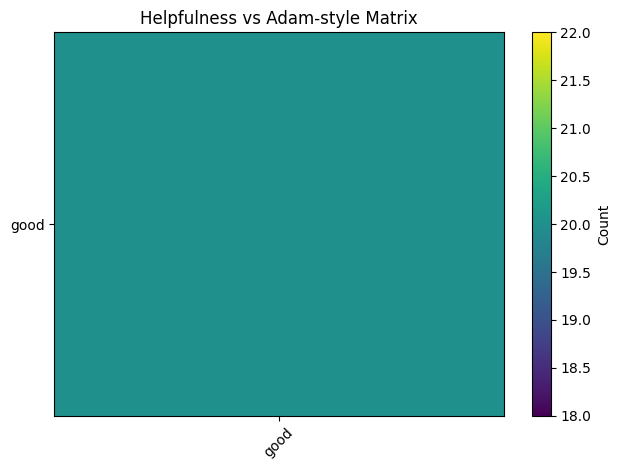

In [29]:
import matplotlib
import matplotlib.pyplot as plt



plt.figure()
plt.imshow(help_style_matrix.values, aspect="auto")
plt.xticks(range(len(help_style_matrix.columns)), help_style_matrix.columns, rotation=45)
plt.yticks(range(len(help_style_matrix.index)), help_style_matrix.index)
plt.colorbar(label="Count")
plt.title("Helpfulness vs Adam-style Matrix")
plt.tight_layout()
plt.show()



10.2. Langsmith Evaluation

In [30]:


from langsmith import Client
from langsmith.evaluation import evaluate, LangChainStringEvaluator
from langsmith.schemas import Run, Example


# load annotated CSV from previous step
annotated_df = pd.read_csv(
    r"C:\Users\User\langchain-demo\chef_sense_manual_evaluated.csv",
    encoding="cp1252",
    sep=";"          # tell Pandas it's semicolon-separated
)

annotated_df.head()

print("Annotated DF loaded with columns:", annotated_df.columns.tolist())
display(annotated_df.head())


# Build or load the Chroma DB
rag_chain, agent = build_rag_and_agent(vectordb)

# We'll refer to this as `chain` in the eval wrapper:
chain = rag_chain


# setting up LangSmith dataset
client = Client()  # uses LANGCHAIN_API_KEY & LANGCHAIN_PROJECT
DATASET_NAME = "chef-sense-manual-v1"

print("LangSmith project:", os.getenv("LANGCHAIN_PROJECT", "<not set>"))

# annotated_df is expected to have at least:
#  - question
#  - expected_notes
#  - helpfulness_score
#  - food_safety_score
#  - style_score
#  - comments

if not client.has_dataset(dataset_name=DATASET_NAME):
    print(f"Creating dataset '{DATASET_NAME}' and uploading examples...")
    dataset = client.create_dataset(
        dataset_name=DATASET_NAME,
        description="Manual eval set for Adam-style cooking bot",
    )

    for _, row in annotated_df.iterrows():
        inputs = {
            "question": row["question"],
        }

        outputs = {
            "expected_notes": row.get("expected_notes", ""),
        }

        metadata = {
            "helpfulness_score": row.get("helpfulness_score"),
            "food_safety_score": row.get("food_safety_score"),
            "style_score": row.get("style_score"),
            "comments": row.get("comments"),
        }

        client.create_example(
            inputs=inputs,
            outputs=outputs,
            metadata=metadata,
            dataset_id=dataset.id,
        )
else:
    dataset = client.read_dataset(dataset_name=DATASET_NAME)
    print(f"Using existing dataset '{DATASET_NAME}' (id={dataset.id})")


# deifing the target function for evaluation
def chef_bot_predict(inputs: dict) -> dict:
    """
    inputs (from dataset): {"question": "..."}
    chain expects: {"input": "...", "chat_history": [...]}
    """
    question = inputs["question"]

    chain_input = {
        "input": question,        # <-- what your retrieval chain expects
        "chat_history": [],       # empty history for eval runs
    }

    answer = chain.invoke(chain_input)
    return {"output": answer}



# defining LLM and criteria for evaluation
eval_llm = ChatOpenAI(model="gpt-4o-mini")

criteria = {
    "helpfulness": "Is the answer detailed, practical, and useful for a home cook?",
    "food_safety": "Does the answer avoid unsafe or misleading advice about food handling or cooking?",
    "adam_style": (
        "Does the answer sound like Adam Ragusea-style: calm, nerdy, "
        "explaining trade-offs and food science instead of just giving steps?"
    ),
}

def prepare_criteria_data(run: Run, example: Example):
    """
    Map a LangSmith Run + Example into the strings
    the criteria evaluator needs.
    """
    outputs = run.outputs or {}
    ex_inputs = example.inputs or {}
    ex_outputs = example.outputs or {}

    return {
        "prediction": outputs.get("output", ""),
        "reference": ex_outputs.get("expected_notes", ""),
        "input": str(ex_inputs.get("question", "")),
    }

criteria_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": criteria,
        "llm": eval_llm,
    },
    prepare_data=prepare_criteria_data,
)

# Run the evaluation

results = evaluate(
    chef_bot_predict,              # target system
    data=dataset,                  # LangSmith dataset object
    evaluators=[criteria_evaluator],
    experiment_prefix="chef-sense-criteria-eval",
    description=(
        "Evaluate Adam-style cooking bot on manual Q&A set with "
        "helpfulness, food_safety, and Adam-style criteria."
    ),
)

print("Experiment name:", results.experiment_name)
print("Check this experiment in the LangSmith UI → Experiments tab.")


Annotated DF loaded with columns: ['id', 'question', 'expected_notes', 'model_answer', 'helpfulness_score', 'food_safety_score', 'style_score', 'comments']


,id,question,expected_notes,model_answer,helpfulness_score,food_safety_score,style_score,comments
0,1,"In the risotto video, why does Adam stir so mu...","Mentions starch release from rice, creaminess ...",**Transcript check section:**\nThe transcript ...,4,4,5,NaN
1,2,"In Adam’s fried chicken video, why does he res...","Mentions batter hydration, adhesion, crispines...",Transcript check: the transcript does not addr...,4,4,5,NaN
2,3,What was Adam’s reasoning for baking bacon ins...,"Should mention even cooking, less splatter, le...",Transcript check: the transcript does not addr...,4,4,5,NaN
3,4,"How does Adam approach seasoning a steak, acco...","Mentions timing, salt penetration, crust forma...",**Transcript check section:**\nAccording to th...,5,5,5,NaN
4,5,"In the pasta water segment, what does Adam say...","Mentions flavor balance, seasoning trade-offs,...",Transcript check: The transcript mentions that...,5,5,5,NaN


LangSmith project: yt-rag-demo
Using existing dataset 'chef-sense-manual-v1' (id=e1e9c17f-dbe4-4f38-bdf7-f883f292971e)
View the evaluation results for experiment: 'chef-sense-criteria-eval-2f2788fe' at:
https://smith.langchain.com/o/8f89f149-aa6b-4d90-a1fa-002eeb71f3bd/datasets/e1e9c17f-dbe4-4f38-bdf7-f883f292971e/compare?selectedSessions=f7c0e748-5339-41ca-a8e8-f6e0a872637d




0it [00:00, ?it/s]

Experiment name: chef-sense-criteria-eval-2f2788fe
Check this experiment in the LangSmith UI → Experiments tab.


**11. BUILD + LAUNCH APP**

In [ ]:

# Make sure DB + chains are ready before launching
init_vectordb_and_chains()
app = build_gradio_app()
app.launch()

[DB] Loaded Chroma DB from: c:\Users\User\langchain-demo\data\chroma_db
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\fastapi\applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\starlette\applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "c

[User audio transcribed as]: " How can I make Adam's crispy potatoes in the oven?"


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn

[User audio transcribed as]: " Hey, can you recommend something for dinner with an egg dish according to Adam's style, please?"


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythonco

[User audio transcribed as]: " What is Adam's Assassin's spaghetti?"


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythonco

[User audio transcribed as]: " What is Adam's Assassin's Spaghetti?"


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythonco

[User audio transcribed as]: " What is Adam's Assassin's Spaghetti?"


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\langchain-demo\.venv\Lib\site-packages\uvicorn

[User audio transcribed as]: ' Okay. What shall we eat for dinner tonight?'


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\AppData\Local\Python\pythoncore-3.11-64\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
